In [1]:
%pylab inline
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from tardis import *
from scipy import sparse,ndimage,interpolate
import corner
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool
from functools import partial
config = tf.ConfigProto() 
config.gpu_options.allow_growth=True

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))

Populating the interactive namespace from numpy and matplotlib
Tensorflow Version:  1.15.2


Using TensorFlow backend.


Running TARDIS 2.1...


In [2]:
class load_universe:

    def __init__(self, tau,nc,bs):

        self.final_tau_RSD = tau
        self.nc = nc
        self.bs = bs
class load_lya():
    def __init__(self,flux_obs,skewers_fin,inverse_covar):
        self.vals_observed = flux_obs
        self.skewers_fin = skewers_fin
        self.inverse_covar = tf.SparseTensorValue(inverse_covar[0],inverse_covar[1],inverse_covar[2])

In [3]:
tau_true = load('tau_128.npy')
flux_true = exp(-tau_true)[0]
skewers_fin = np.load('hydro128/skewers_fin.npy')
flux_obs = np.load('hydro128/flux_obs.npy')
inverse_covar = np.load('hydro128/inverse_covar.npy',allow_pickle=True)
uni_final_tau_RSD = np.load('hydro128/uni_final_tau_RSD.npy')
flux_contrast = flux_obs/flux_obs.mean()-1
uni = load_universe(tau=tau_true,nc=128,bs=128)
mock_lya = load_lya(flux_obs,skewers_fin,inverse_covar)

<d_los>=4.000 Mpc/h


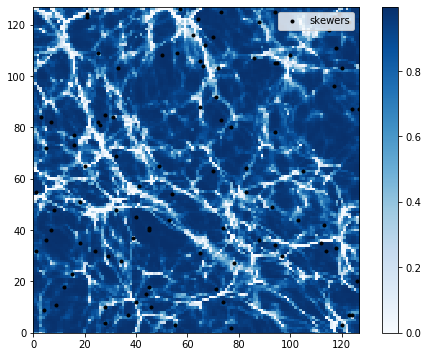

In [4]:
n_los = 100
n = 128
figure(figsize=(8,6))
mock_lya = lya_survey(uni,2,2,sm=0.5,n_skewers=n_los)
mock_lya.select_skewers()
imshow(np.exp(-1*uni.final_tau_RSD[0,:,:,0]),cmap="Blues")
colorbar()
scatter(mock_lya.skewers_fin[::n][:,1],mock_lya.skewers_fin[::n][:,0],color='k',marker='.',label='skewers')
legend(loc=1)
ylim(0,127)
xlim(0,127)
print('<d_los>=%.3f Mpc/h'%(40/n_los**0.5))

In [5]:
def chi(inputs, data, inverse_covar):

    residual = tf.subtract(inputs, data)
    a = tf.sparse.sparse_dense_matmul(inverse_covar, residual,adjoint_b=True)
    value = tf.matmul(residual,a)
    return value

def overone(flux):

    flux = K.clip(flux,1,None)
    return(tf.reduce_sum(flux))

def nodes(flux):

    flux = K.clip(flux,0,0.4)
    return(tf.reduce_sum(flux))
#The final loss functon we want to minimize

tf.compat.v1.reset_default_graph()
lya = mock_lya
anneal_steps=[2.5,2,1.5,0.7]
k=[6,6,0.4,0.1]
nc = 128
bs = 128
gtol=1e-5/512
maxiter=[50,50,60,30]
kvec = fftk((nc,nc,nc), symmetric=False)
kmesh = sum((np.array(kvec,dtype=object))**2)**0.5
pkmesh = ipklin(kmesh)

initial=tf.Variable(np.zeros(shape=(1,nc,nc,nc)),dtype='float32',trainable=True)
RSD_tau = tf.multiply(initial,1)
Rs = tf.placeholder(tf.float64, shape = [1], name='smoothing')

sum_op = reduce_sum_det
Rsm = tf.multiply(Rs, 1)

flux = tf.exp(-RSD_tau)
flux_s = smoothing(flux,Rsm,kmesh,nc)
yy_lya = tf.placeholder(tf.float32, [lya.skewers_fin.shape[0]]) #lya flux
flux_val = flowpm.cic_readout(flux_s,np.array(lya.skewers_fin,dtype=np.float32).reshape(1,-1,3))
obj_fun = k[0]*(chi(flux_val,yy_lya,lya.inverse_covar)+k[1]*sum_op(tf.square(tf.subtract(flux_s,flux)))
            +k[2]*overone(flux)+k[3]*nodes(flux))

sess = tf.Session()
sess.run(tf.compat.v1.global_variables_initializer())

time_start = time.time()
for nn,r0 in enumerate(anneal_steps):
    opt = ScipyOptimizerInterface(obj_fun, var_list=[initial], method='L-BFGS-B',
                                       options={'maxiter': maxiter[nn], 'gtol':gtol,'disp': True})

    z = opt.minimize(sess, {yy_lya:lya.vals_observed,Rs:[r0]})
time_end = time.time()
print('Total run time %f'%(time_end-time_start))
recon_RSD_tau,recon_flux = sess.run([RSD_tau,flux_val],{yy_lya:lya.vals_observed,Rs:[0]})

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 5620354.500000
  Number of iterations: 50
  Number of functions evaluations: 57
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5619830.000000
  Number of iterations: 43
  Number of functions evaluations: 61
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 5618807.500000
  Number of iterations: 60
  Number of functions evaluations: 61
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 5612157.500000
  Number of iterations: 30
  Number of functions evaluations: 31
Total run time 78.125233


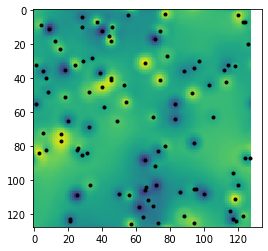

In [6]:
imshow(exp(-recon_RSD_tau)[0,...,0])
scatter(mock_lya.skewers_fin[::n][:,1],mock_lya.skewers_fin[::n][:,0],color='k',marker='.',label='skewers')

In [7]:
jac1 = opt.result.jac
jac1=jac1.reshape(128,128,128)

In [105]:
d_f = zeros([n,n])
t1 = time.time()
RSD_tau_tf = tf.placeholder(tf.float32, shape = [1,n,n,n])
flux = tf.exp(-RSD_tau_tf)
flux_s = smoothing(flux,Rsm,kmesh,nc)
flux_val = flowpm.cic_readout(flux_s,np.array(lya.skewers_fin,dtype=np.float32).reshape(1,-1,3))
obj_fun2 = k[0]*(chi(flux_val,yy_lya,lya.inverse_covar)+k[1]*sum_op(tf.square(tf.subtract(flux_s,flux)))
                    +k[2]*overone(flux)+k[3]*nodes(flux))
sess.run(tf.compat.v1.global_variables_initializer())
loss_0 = sess.run(obj_fun2,{yy_lya:lya.vals_observed,Rs:[0.7],RSD_tau_tf:recon_RSD_tau.copy()})[0][0]
for i in range(n):
    for j in range(n):
        RSD_tau2 = recon_RSD_tau.copy()
        RSD_tau2[0][i,j,0] = RSD_tau2[0][i,j,0]+1
        a = sess.run(obj_fun2,{yy_lya:lya.vals_observed,Rs:[0.7],RSD_tau_tf:RSD_tau2})
        print('\r'+str(time.time()-t1),end=' ')
        d_f[i,j]=a[0][0]
d_f = d_f-loss_0

565.6713168621063                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [9]:
d_f2 = zeros([n,n])
t1 = time.time()
RSD_tau_tf = tf.placeholder(tf.float32, shape = [1,n,n,n])
flux = tf.exp(-RSD_tau_tf)
flux_s = smoothing(flux,Rsm,kmesh,nc)
flux_val = flowpm.cic_readout(flux_s,np.array(lya.skewers_fin,dtype=np.float32).reshape(1,-1,3))
obj_fun2 = k[0]*(chi(flux_val,yy_lya,lya.inverse_covar)+k[1]*sum_op(tf.square(tf.subtract(flux_s,flux)))
                    +k[2]*overone(flux)+k[3]*nodes(flux))
sess.run(tf.compat.v1.global_variables_initializer())
loss_0 = sess.run(obj_fun2,{yy_lya:lya.vals_observed,Rs:[0.7],RSD_tau_tf:recon_RSD_tau.copy()})[0][0]
for i in range(n):
    for j in range(n):
        RSD_tau2 = recon_RSD_tau.copy()
        RSD_tau2[0][i,j,64] = RSD_tau2[0][i,j,64]+1
        a = sess.run(obj_fun2,{yy_lya:lya.vals_observed,Rs:[0.7],RSD_tau_tf:RSD_tau2})
        print('\r'+str(time.time()-t1),end=' ')
        d_f2[i,j]=a[0][0]
d_f2 = d_f2-loss_0

545.6959478855133                                                                                                                                                                                                                                                                                                                                                                                 

(0, 127)

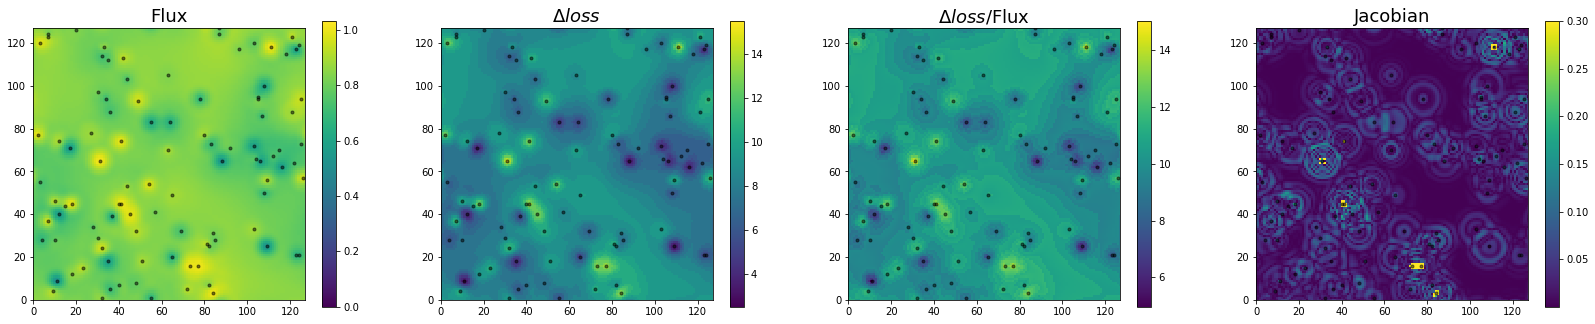

In [106]:
figure(figsize=(28,7))
subplot(141)
imshow(exp(-recon_RSD_tau[0,...,0]).T,vmin=0)
colorbar(shrink=0.75)
title('Flux',fontsize=18)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
xlim(0,127)
ylim(0,127)
subplot(142)
imshow(abs(d_f).T)
title(r'$\Delta loss$',fontsize=18)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
xlim(0,127)
ylim(0,127)
subplot(143)
imshow((abs(d_f)/exp(-recon_RSD_tau[0,...,0])).T)
title(r'$\Delta loss$/Flux',fontsize=18)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
xlim(0,127)
ylim(0,127)
subplot(144)
imshow(abs(jac1[:,:,0].T),vmax=0.3)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
title('Jacobian',fontsize=18)
xlim(0,127)
ylim(0,127)

(0, 127)

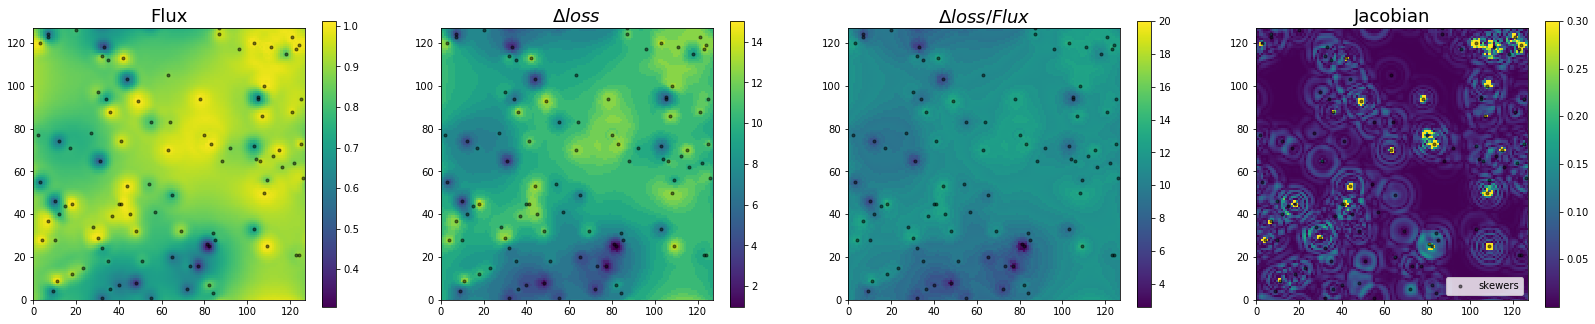

In [100]:
figure(figsize=(28,7))
subplot(141)
imshow(exp(-recon_RSD_tau[0,...,64]).T)
colorbar(shrink=0.75)
title('Flux',fontsize=18)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
xlim(0,127)
ylim(0,127)
subplot(142)
imshow(abs(d_f2).T,vmax=15)
title(r'$\Delta loss$',fontsize=18)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
xlim(0,127)
ylim(0,127)
subplot(143)
imshow((abs(d_f2)/exp(-recon_RSD_tau[0,...,64])).T,vmax=20)
title(r'$\Delta loss/Flux$',fontsize=18)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
xlim(0,127)
ylim(0,127)
subplot(144)
imshow(abs(jac1[:,:,64].T),vmax=0.3)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
title('Jacobian',fontsize=18)
legend()
xlim(0,127)
ylim(0,127)

Get another jacobian from tardis reconstruction

In [112]:
n=64
uni2 = universe(bs=n, nc=n,z_f=2.0,ipklin = ipklin )
uni2.evolv() #run the simulation

(64, 64, 64)
262144 65 262144
Total run time 8.673782348632812


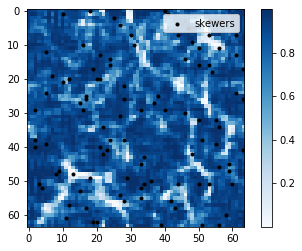

In [114]:
n_los = 100
mock_lya2 = lya_survey(uni2,2,2,sm=0.5,n_skewers=n_los)
mock_lya2.select_skewers()
imshow(np.exp(-1*uni2.final_tau_RSD[0,:,:,0]),cmap="Blues")
colorbar()
plt.scatter(mock_lya2.skewers_fin[::n][:,0],mock_lya2.skewers_fin[::n][:,1],color='k',marker='.',label='skewers')
legend(loc=1)

In [115]:
mock_gal = gal_survey(uni2,32*32)
mock_gal.select_galaxies() 
loc = mock_gal.samples_n

In [117]:
lya_recon = reconstruct_tardis(uni2,lya=mock_lya2,gal=mock_gal, specz_fac=0.0,lya_fac=1.0,pk_fac=0,anneal_steps=[5,3,2,0],maxiter=[5,5,5,20])  
lya_recon.initmodel()
lya_recon.run_model()

(64, 64, 64)
262144 65 262144
r0,  5
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 68716.921875
  Number of iterations: 5
  Number of functions evaluations: 9
Run Time:  16.244837999343872
r0,  3
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 67031.421875
  Number of iterations: 5
  Number of functions evaluations: 9
Run Time:  32.47292947769165
r0,  2
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 64501.402344
  Number of iterations: 5
  Number of functions evaluations: 9
Run Time:  51.97794818878174
r0,  0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 38589.562500
  Number of iterations: 20
  Number of functions evaluations: 22
Run Time:  78.927134

In [119]:
jac_tardis = lya_recon.opt.result.jac.reshape(64,64,64)

Text(0.5, 1.0, 'Jacobian')

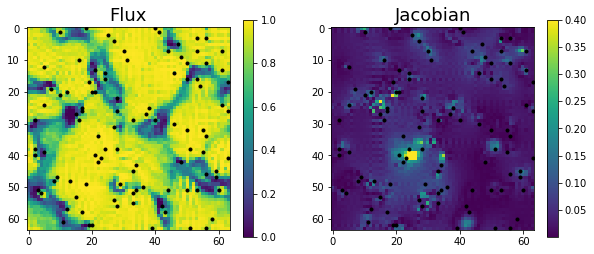

In [139]:
figure(figsize=(10,4))
subplot(121)
imshow(exp(-lya_recon.recon_RSD_tau[0,...,0]).T)
colorbar()
title('Flux',fontsize=18)
plt.scatter(mock_lya2.skewers_fin[::n][:,0],mock_lya2.skewers_fin[::n][:,1],color='k',marker='.',label='skewers')
subplot(122)
imshow(abs(jac_tardis[...,32]).T,vmax=0.4)
colorbar()
plt.scatter(mock_lya2.skewers_fin[::n][:,0],mock_lya2.skewers_fin[::n][:,1],color='k',marker='.',label='skewers')
title('Jacobian',fontsize=18)
